## The Context
In a previous [post](https://cgcooke.github.io/Blog/ar/computer%20vision/blender/visualisation/2021/02/17/An-Introduction-To-Augemented-Reality.html), I looked at how we could integrate synthetic objects into real-world imagery by determining the position and orientation of the camera.

Using the OpenCV *solvePnP* function, we can find the position and orientation of the "chessboard" with respect to the camera. I used a "chessboard" type pattern in the post and used the detected corners to orient the camera. This is because the detected 2d points in the image have corresponding points in 3d space.

When we detect a tag, we can decode its number. In practice, an [ArUco Tag](https://en.wikipedia.org/wiki/ARTag), a type of fiducial/target, is often used. ArUco tags come in sets called dictionaries; the image below is tag number 0 out of a group of 50.

![An ArUco tag](https://cgcooke.github.io/Blog//images/2021-02-24-Positioning-Using-ArUco-Tags/Tag.png)


Let's walk through how to detect tags and then determine a camera's position and orientation with respect to them in OpenCV.


## Detecting Tags
As always, let's start by importing what we need.

In [1]:
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot

plt.rcParams['figure.figsize'] = [20,20]

I've already calibrated the camera, which means that we have both the camera matrix (K) and the distortion parameters for the camera.

In [2]:
K = np.array([[3286.9, 0.0 , 2032.8],
              [0.0   , 3282.3, 1519.1],
              [0.0   , 0.0   ,    1.0]])

dist = np.array([[2.44663616e-01],[-1.48023303e+00],[2.04607109e-03],[1.53484564e-03],[2.56349651e+00]])

Now we need to configure our ArUco code detector. 

Firstly, we configure it to look for a "4X4_50" type tag. 

In [3]:
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)

Secondly, we tell it that we want to configure the detector; in particular, we want to find the corners to a very high degree of accuracy (Sub-Pixel).

In [4]:
arucoParams = cv2.aruco.DetectorParameters_create()
arucoParams.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
arucoParams.cornerRefinementWinSize = 25

Now we can:
* Load an image
* Convert to grayscale
* Detect the tags

In [5]:
fname = 'data/2021-02-24-Positioning-Using-ArUco-Tags/ArUco.jpg'
img = cv2.imread(fname)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

(detected_tags, tag_ids, rejected) = cv2.aruco.detectMarkers(gray, arucoDict, parameters=arucoParams)

Now that we have detected the tags, let's visualise them: 

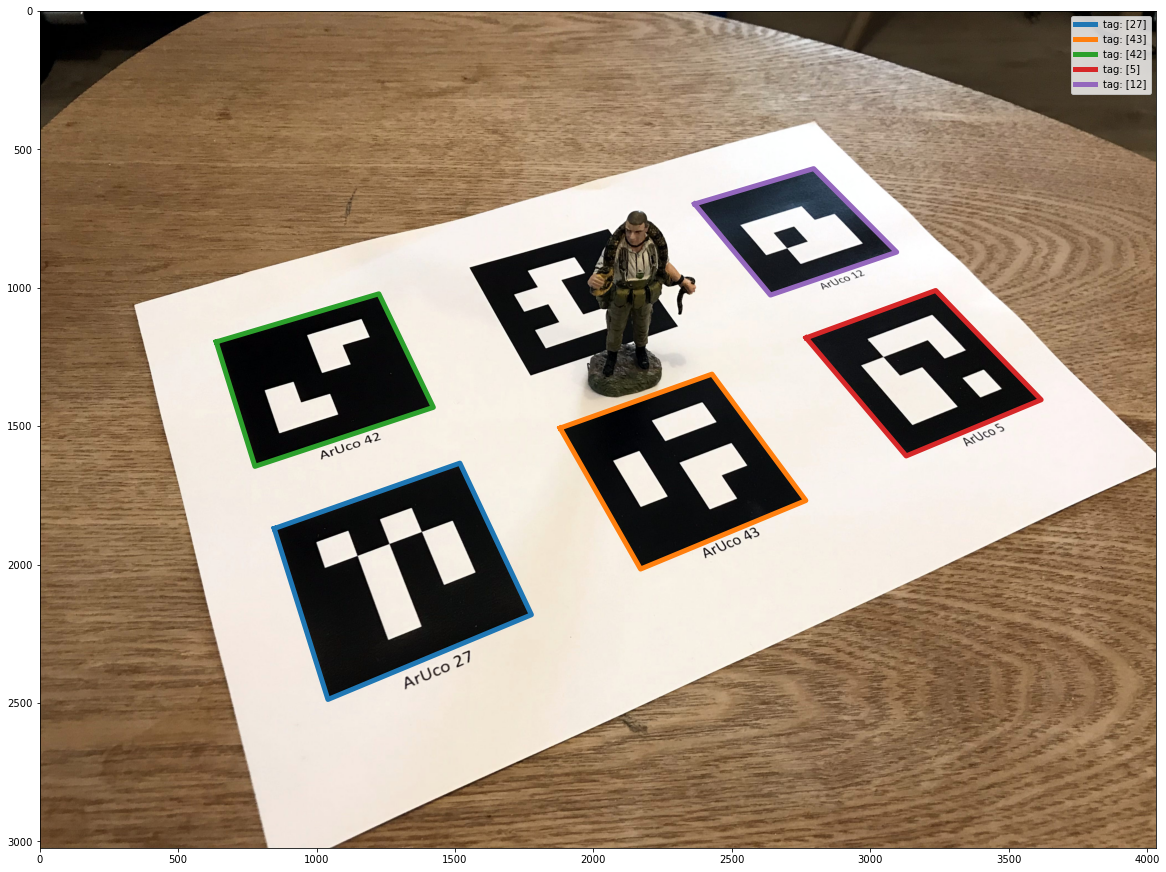

In [6]:
def plot_squares(detected_tags, tag_ids):
    plt.imshow(img[:,:,::-1])
    for i in range(0,len(detected_tags)):
        square = detected_tags[i]
        square = square.squeeze()
        x = []
        y = []
        for j in range(0,5):
            v1 = square[j%4]
            x.append(v1[0])
            y.append(v1[1])
                     
        plt.plot(x, y, label='tag: ' + str(tag_ids[i]), linewidth=5)
    plt.legend()
    plt.show()

plot_squares(detected_tags, tag_ids)

## Finding the tag position and orientation

Now that we have detected the tags, we can compute the position and orientation of the tag with respect to the camera.

In practice, if we can find the position and orientation of the tag with respect to the camera, we can, conversely, find the position and orientation of the camera with respect to the tag.

When *cv2.aruco.detectMarkers* detects a tag; it gives us the tag coordinates, starting from the top left and proceeding in a counterclockwise direction around the tag.

If we use the tag as the origin for a right-handed - coordinate system and place the origin at the lower-left corner of the tag, we find the 3D coordinates of the corners of the tags are as follows.

In [7]:
points_3d = np.array([[0.0,1.0,0.0],
                      [1.0,1.0,0.0],
                      [1.0,0.0,0.0],
                      [0.0,0.0,0.0]])

With the 2d coordinates and corresponding 3d coordinates for the corners of each tag, we can find the relationship between the camera and the tag.

The can be computed using *cv2.solvePnP*, which will give us the *rvec* and *tvec*, which describes the position and orientation of the tag according to the coordinate system of the camera.

![](https://cgcooke.github.io/Blog//images/2021-02-17-An-Introduction-To-Augemented-Reality/pinholeCamera.png)

In this case, *rvec* is in [Rodrigues](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula) format.

Finally, let's visualize the coordinate system defined by each ArUco tag.

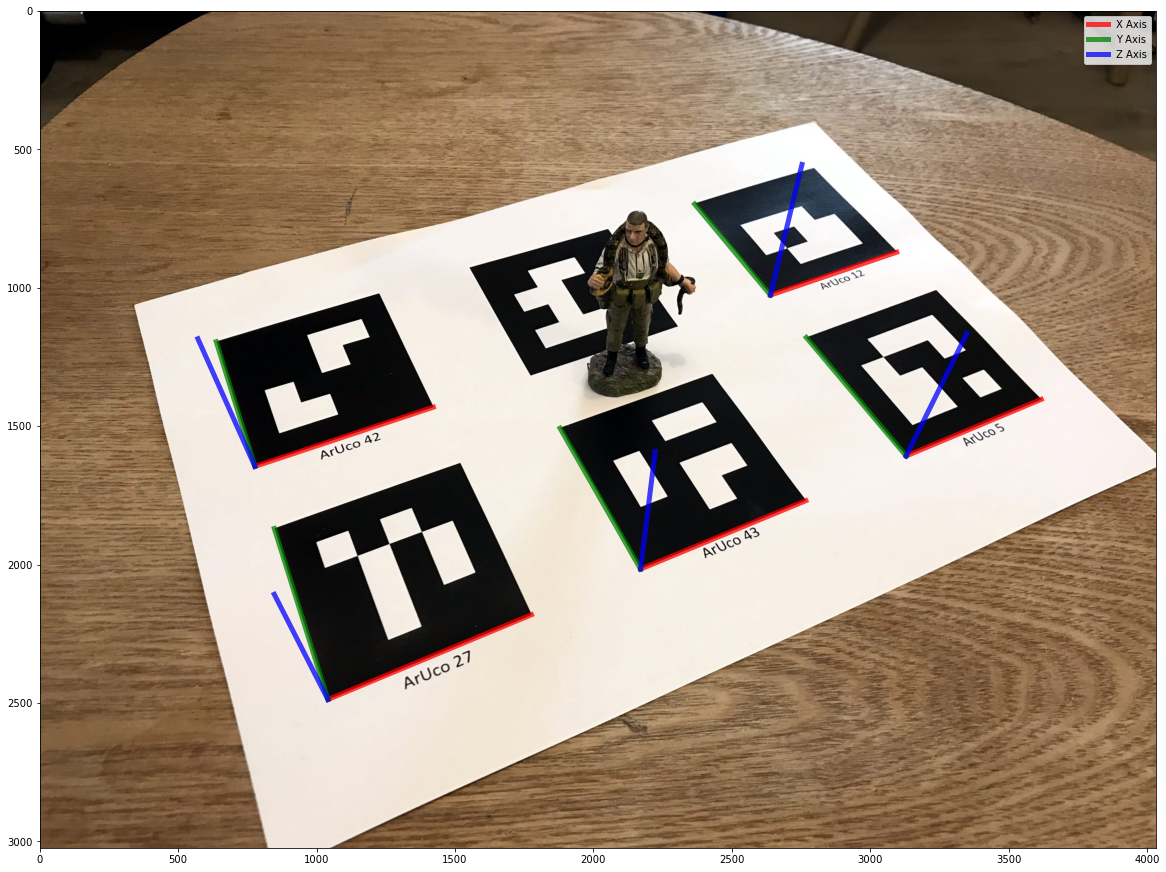

In [8]:
for i in range(len(detected_tags)):
    points_2d = detected_tags[i].squeeze()

    ret, rvec, tvec = cv2.solvePnP(objectPoints = points_3d, imagePoints = points_2d, cameraMatrix = K, distCoeffs = dist)#, flags = cv2.SOLVEPNP_IPPE_SQUARE)
    
    axis = np.float32([[1,0,0], [0,1,0], [0,0,1]]).reshape(-1,3)
    imgpts, jac = cv2.projectPoints(axis, rvec, tvec, K, dist)
    imgpts = np.squeeze(imgpts)
    cx, cy = points_2d[3,0], points_2d[3,1]
    plt.imshow(img[:,:,::-1])

    if i ==0:
        plt.plot([cx,imgpts[0,0]],[cy, imgpts[0,1]], color='r', alpha=0.75, linewidth=5, label='X Axis')
        plt.plot([cx,imgpts[1,0]],[cy, imgpts[1,1]], color='g', alpha=0.75, linewidth=5, label='Y Axis')
        plt.plot([cx,imgpts[2,0]],[cy, imgpts[2,1]], color='b', alpha=0.75, linewidth=5, label='Z Axis')
    else:
        plt.plot([cx,imgpts[0,0]],[cy, imgpts[0,1]], color='r', alpha=0.75, linewidth=5)
        plt.plot([cx,imgpts[1,0]],[cy, imgpts[1,1]], color='g', alpha=0.75, linewidth=5)
        plt.plot([cx,imgpts[2,0]],[cy, imgpts[2,1]], color='b', alpha=0.75, linewidth=5)

plt.legend()
plt.show()

## Finding the camera position and orientation
For completeness, we can find the location and orientation of the camera with respect to one of the tags.

In this case, it will be the first tag we detected, tag number 27, in the low left of the image.

In [9]:
tag_index = 0
points_2d = detected_tags[tag_index].squeeze()

ret, rvec, tvec = cv2.solvePnP(objectPoints = points_3d, imagePoints = points_2d, cameraMatrix = K, distCoeffs = dist)#, flags = cv2.SOLVEPNP_IPPE_SQUARE)

Now we can find the camera position *Camera_C*and its orientation *Camera_R* (in Quaternions), with respect to the coordinate system defined by the tag.

In [10]:
r = Rot.from_rotvec(rvec[:,0])
R = r.as_matrix()
t = np.array(tvec)

Camera_C = -np.dot(R.T,tvec)
print(Camera_C)

Camera_R = Rot.from_matrix(R.T).as_quat()
print(Camera_R)

[[ 0.27833657]
 [-1.92925962]
 [ 4.07499752]]
[ 0.9225515  -0.20544298  0.09037747 -0.31388505]


## Conclusion

For me, ArUco tags offer many exciting possibilities beyond Augmented Reality.

In particular, they can be applied during photogrammetric surveying projects to estimate camera positions and orientations quickly.

They also allow us to inject scale estimates into a photogrammetric reconstruction, given their known real-world size.